In [1]:
import tensorflow as tf
import copy
from tensorflow.keras.models import Model
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from PIL import Image

from utils import labelled_unlabbeled_split_fpaths, visualise_hidden_space

from skin_loader import load_data, model_predict

from ItCModel import ItCModel_Skin
from CtLModel import CtLModel

from utils import plot_summary

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
#'../DL-Models-ISIC/results-comet-iv4/iv4_i18nf_5runs_4/checkpoints/model_best.pth'
#'../DL-Models-ISIC/keras_h5/rn50_t3i2018_nf.h5'


args = {
    'model_path':'../../../DL-Models-ISIC/keras_h5/rn50_t3i2018_nf.h5',
    'path_npy': '../../../isic-data/edraAtlas/derm7pt/',
    'path_imgs': '../../../isic-data/edraAtlas/allimages/',
    'itc_model': 'LR',
    'n_labelled': 609,
    'n_unlabelled':None
}

extr_method         = args['itc_model']
n_labelled          = args['n_labelled']
n_unlabelled        = args['n_unlabelled']

In [3]:


#Load model and data
model = tf.keras.models.load_model(args['model_path'])
img_names_train, X_attr_train, y_train, img_names_test, X_attr_test, y_test, attr_names = load_data(args['path_npy'])
print("Loaded  model and data successfully...")


/usr/local/lib/python3.8/dist-packages/keras/layers/core/lambda_layer.py:297: UserWarning: onnx2keras.pooling_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
/usr/local/lib/python3.8/dist-packages/keras/layers/core/lambda_layer.py:297: UserWarning: onnx2keras.reshape_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
2022-11-17 23:39:37.357048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 23:39:38.111461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 

Loaded  model and data successfully...


In [4]:
## Selecting only 25 concepts that belong to derm7pt
concepts_names_25 = np.array(['Pigment_net:absent', 'Pigment_net:atypical', 'Pigment_net:typical', 'Dots_globules:absent', 'Dots_globules:irregular', 'Dots_globules:regular', 'Streaks:absent', 'Streaks:irregular', 'Streaks:regular', 'BW_Veil:present', 'Pigmentation:absent', 'Pigmentation:diffuse irregular', 'Pigmentation:diffuse regular', 'Pigmentation:localized irregular', 'Regression_structures:absent', 'Regression_structures:blue areas', 'Regression_structures:combinations', 'Regression_structures:white areas', 'Vascular_structures:absent', 'Vascular_structures:arborizing', 'Vascular_structures:comma', 'Vascular_structures:dotted', 'Vascular_structures:hairpin', 'Vascular_structures:linear-irregular', 'Vascular_structures:within regression'])
idx_concepts= [ np.where(attr_names == i)[0][0] for i in concepts_names_25]
#idx_concepts

X_attr_train = X_attr_train[:,idx_concepts]
attr_names = attr_names[idx_concepts]
X_attr_test = X_attr_test[:,idx_concepts]


In [5]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 LAYER_0_pad (ZeroPadding2D)    (None, 230, 230, 3)  0           ['input_0[0][0]']                
                                                                                                  
 LAYER_0 (Conv2D)               (None, 112, 112, 64  9472        ['LAYER_0_pad[0][0]']            
                                )                                                                 
                                                                                              

In [6]:

# Evaluate network metrics
score_test, y_test_pred,y_verify = model_predict(model,args,mode = 'test')
print('Original Model Test AUC: {}'.format(score_test))


acc = accuracy_score(y_test, y_test_pred)
print("Test accuracy of model: ", acc)

Found 261 validated image filenames belonging to 2 classes.


/code/cme/CME/skin/skin_loader.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['label']=sub_df.label.astype(str)
/code/cme/CME/skin/skin_loader.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['image'] = sub_df['image'].astype(str) + '.jpg'
2022-11-17 23:39:42.067182: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


Original Model Test AUC: 0.8147226173541963
Test accuracy of model:  0.7739463601532567


In [7]:
score_train, y_train_pred,y_verf = model_predict(model,args,mode='train')
print('Original Model Training AUC: {}'.format(score_train))

Found 609 validated image filenames belonging to 2 classes.


/code/cme/CME/skin/skin_loader.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['label']=sub_df.label.astype(str)
/code/cme/CME/skin/skin_loader.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['image'] = sub_df['image'].astype(str) + '.jpg'


Original Model Training AUC: 0.780652949821541


In [8]:
score_full, y_full_pred, y_full_ver = model_predict(model,args,mode='full')
print('Original Model Full AUC: {}'.format(score_full))

Found 870 validated image filenames belonging to 2 classes.
Original Model Full AUC: 0.7909218164072533


In [9]:
layer_names_complete = [i.name for i in model.layers]
# for i,j in enumerate(layer_names_complete):
#     print (i, j)

In [13]:
layer_ids = [112, 137]

In [14]:

layer_names = [layer_names_complete[i] for i in layer_ids]
layer_ids,layer_names

([112, 137], ['LAYER_96', 'LAYER_118'])

In [15]:

params = {"layer_ids":      layer_ids,
          "layer_names":    layer_names,
          "concept_names":  attr_names,
          "method":         extr_method,
          "n_concepts": len(attr_names),
         'imgs_folder': args['path_imgs']}

In [16]:
# Split into labelled and unlabelled
x_train_l_paths, c_train_l, x_train_u_paths, c_train_u = labelled_unlabbeled_split_fpaths(img_names_train, X_attr_train,
                                                                       n_labelled=n_labelled,
                                                                       n_unlabelled=n_unlabelled)

print("Split into labelled/unlabelled")


x_train_l length: 609
c_train_l shape: (609, 25)
x_train_u length: 0
c_train_u shape: (0, 25)
Split into labelled/unlabelled


In [17]:
conc_extractor = ItCModel_Skin(model, **params)
conc_extractor.train(x_train_l_paths, c_train_l, x_train_u_paths)
print("Concept Summary extracted successfully...")



Compute activations for specified layers
layer_id 112
Processing batch  0  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
layer_id 137
Processing batch  0  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
--- Processing layer (generatin a clf for each concept)  1  of  2
concept nro 0
(92, 2)
concept nro 1
(92, 2)
concept nro 2
(92, 2)
concept nro 3
(92, 2)
concept nro 4
(92, 2)
concept nro 5
(92, 2)
concept nro 6
(92, 2)
concept nro 7
(92, 2)
concept nro 8
(92, 2)
concept nro 9
(92, 2)
concept nro 10
(92, 2)
concept nro 11
(92, 2)
concept nro 12
(92, 2)
concept nro 13
(92, 2)
concept nro 14
(92, 2)
concept nro 15
(92, 2)
concept nro 16
(92, 2)
concept nro 17
(92, 2)
concept nro 18
(92, 2)
concept nro 19
(92, 2)
concept nro 20
(92, 2)
concept nro 21
(92, 2)
concept nro 22
(92, 2)
concept nro 23
(92, 2)
concept nro 24
(92, 2)
--- Processing layer (generatin 

In [18]:
#layer used to predict each concept
for con,i in enumerate(conc_extractor.concept_predictor_layer_ids):
    print(con,layer_names_complete[i])

0 LAYER_96
1 LAYER_118
2 LAYER_118
3 LAYER_96
4 LAYER_96
5 LAYER_96
6 LAYER_118
7 LAYER_96
8 LAYER_96
9 LAYER_96
10 LAYER_96
11 LAYER_118
12 LAYER_118
13 LAYER_118
14 LAYER_118
15 LAYER_118
16 LAYER_96
17 LAYER_118
18 LAYER_96
19 LAYER_96
20 LAYER_96
21 LAYER_118
22 LAYER_96
23 LAYER_118
24 LAYER_118


In [19]:
# number of times each layer was used to predict concepts"
for i in layer_ids:
    print(i, layer_names_complete[i],conc_extractor.concept_predictor_layer_ids.count(i))

112 LAYER_96 13
137 LAYER_118 12


In [20]:
c_test_extr , c_test_extr_prob  = conc_extractor.predict_concepts(img_names_test)

Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
P

In [21]:
c_test_extr_prob.shape

(261, 25)

In [22]:
exp_results_dict = {}

In [23]:
# Plot per-concept accuracy:
accuracies = [accuracy_score(X_attr_test[:, i], c_test_extr[:, i])*100 for i in range(X_attr_test.shape[1])]
roc_auc_scores = [roc_auc_score(X_attr_test[:, i], c_test_extr[:, i]) for i in range(X_attr_test.shape[1])]
f1s = [f1_score(X_attr_test[:, i], c_test_extr[:, i])*100 for i in range(X_attr_test.shape[1])]
print("F1s: ")
print(f1s)
print("roc_auc_scores ")
print(roc_auc_scores)
print("Avg acc.: ", str(sum(accuracies)/len(accuracies)))
print("Avg f1.: ", str(sum(f1s)/len(f1s)))
print("Avg ROC-AUC Score: ", str(sum(roc_auc_scores)/len(roc_auc_scores)))

F1s: 
[62.576687116564415, 42.20183486238532, 68.54460093896715, 27.397260273972602, 65.83333333333334, 52.22929936305732, 80.96676737160121, 47.27272727272727, 47.36842105263157, 64.58333333333333, 76.76767676767676, 44.44444444444444, 41.50943396226415, 0.0, 86.28428927680798, 16.216216216216214, 12.121212121212121, 14.285714285714288, 90.75268817204301, 0.0, 0.0, 13.333333333333334, 0.0, 0.0, 9.523809523809526]
roc_auc_scores 
[0.7196563888163051, 0.6280835710689713, 0.7317926333413058, 0.5714916151809356, 0.6843961123622141, 0.6520296899632159, 0.7351091379948206, 0.6494310099573257, 0.6666939443535189, 0.7548344947735192, 0.7313513513513512, 0.6261304670126019, 0.6616379310344828, 0.5, 0.6921449453762116, 0.540671031096563, 0.5292765174739423, 0.5384615384615384, 0.5674587393119905, 0.5, 0.5, 0.5376506024096386, 0.5, 0.498015873015873, 0.524348635235732]
Avg acc.:  84.96551724137933
Avg f1.:  38.56852332088382
Avg ROC-AUC Score:  0.6096266491836824


In [24]:
for cont,f11 in enumerate(f1s):
    f11

In [25]:
for cont, i in enumerate(attr_names):
    print(cont, i,roc_auc_scores[cont])

0 Pigment_net:absent 0.7196563888163051
1 Pigment_net:atypical 0.6280835710689713
2 Pigment_net:typical 0.7317926333413058
3 Dots_globules:absent 0.5714916151809356
4 Dots_globules:irregular 0.6843961123622141
5 Dots_globules:regular 0.6520296899632159
6 Streaks:absent 0.7351091379948206
7 Streaks:irregular 0.6494310099573257
8 Streaks:regular 0.6666939443535189
9 BW_Veil:present 0.7548344947735192
10 Pigmentation:absent 0.7313513513513512
11 Pigmentation:diffuse irregular 0.6261304670126019
12 Pigmentation:diffuse regular 0.6616379310344828
13 Pigmentation:localized irregular 0.5
14 Regression_structures:absent 0.6921449453762116
15 Regression_structures:blue areas 0.540671031096563
16 Regression_structures:combinations 0.5292765174739423
17 Regression_structures:white areas 0.5384615384615384
18 Vascular_structures:absent 0.5674587393119905
19 Vascular_structures:arborizing 0.5
20 Vascular_structures:comma 0.5
21 Vascular_structures:dotted 0.5376506024096386
22 Vascular_structures:ha

In [26]:
f1s=np.array(f1s)
roc_auc_scores= np.array(roc_auc_scores)
print(len(f1s[f1s>50]))
roc_auc_scores[roc_auc_scores>0.57]

9


array([0.71965639, 0.62808357, 0.73179263, 0.57149162, 0.68439611,
       0.65202969, 0.73510914, 0.64943101, 0.66669394, 0.75483449,
       0.73135135, 0.62613047, 0.66163793, 0.69214495])

In [27]:
exp_results_dict["phat_c_auc_list"] = roc_auc_scores
exp_results_dict["phat_c_names"] = attr_names
exp_results_dict["phat_c_auc_avg"] = sum(roc_auc_scores)/len(roc_auc_scores)

In [28]:
exp_results_dict

{'phat_c_auc_list': array([0.71965639, 0.62808357, 0.73179263, 0.57149162, 0.68439611,
        0.65202969, 0.73510914, 0.64943101, 0.66669394, 0.75483449,
        0.73135135, 0.62613047, 0.66163793, 0.5       , 0.69214495,
        0.54067103, 0.52927652, 0.53846154, 0.56745874, 0.5       ,
        0.5       , 0.5376506 , 0.5       , 0.49801587, 0.52434864]),
 'phat_c_names': array(['Pigment_net:absent', 'Pigment_net:atypical',
        'Pigment_net:typical', 'Dots_globules:absent',
        'Dots_globules:irregular', 'Dots_globules:regular',
        'Streaks:absent', 'Streaks:irregular', 'Streaks:regular',
        'BW_Veil:present', 'Pigmentation:absent',
        'Pigmentation:diffuse irregular', 'Pigmentation:diffuse regular',
        'Pigmentation:localized irregular', 'Regression_structures:absent',
        'Regression_structures:blue areas',
        'Regression_structures:combinations',
        'Regression_structures:white areas', 'Vascular_structures:absent',
        'Vascular_struc

In [29]:
# Concept values predicted by p-hat
c_train_extr = conc_extractor.predict_concepts(img_names_train)
c_test_extr = conc_extractor.predict_concepts(img_names_test)

Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
Processing batch  3  of  5
Processing batch  4  of  5
Processing batch  5  of  5
Processing batch  1  of  5
Processing batch  2  of  5
P

## Concept to Label 

In [30]:
# Train concept to label model
# Specify model extraction parameters

CModel_method = "LR"
params = {"method": CModel_method, "concept_names": attr_names}

# q-hat trained on predicted concept values
lr_conc_model = CtLModel(c_train_extr[0], y_train_pred, **params)






In [31]:



f_prob= lr_conc_model.clf.predict_proba(c_test_extr[0])[:,1]
q_roc_fid=roc_auc_score(y_test_pred, f_prob)
print("ROC AUC Score (fidelity) - f-hat trained on predicted concepts compared to predicted labels with the model "
      , q_roc_fid)


# Save fhat accuracy
exp_results_dict["f_hat_lr_fidelity"] = q_roc_fid

# Compute accuracy, to compare to model
f_roc_score=roc_auc_score(y_test, f_prob)
print("task_Perf ROC AUC Score - f-hat trained on predicted concepts compared to real labels ", f_roc_score)

exp_results_dict["f_hat_lr_task_perf"] = f_roc_score

# Evaluate performance of q-hat, trained on p-hat-computed values
q_prob_2= lr_conc_model.clf.predict_proba(X_attr_test)[:,1]
q_roc_2=roc_auc_score(y_test, q_prob_2)
print(" TASK peRF ROC AUC SCORE q-hat (trained on predicted concepts), using to predict the test ground-truth concepts: ", 
      q_roc_2)

# Plot the f-hat model
plot_summary(lr_conc_model)

#print(exp_results_dict)


ROC AUC Score (fidelity) - f-hat trained on predicted concepts compared to predicted labels with the model  0.8267647989870212
task_Perf ROC AUC Score - f-hat trained on predicted concepts compared to real labels  0.8480440967283072
 TASK peRF ROC AUC SCORE q-hat (trained on predicted concepts), using to predict the test ground-truth concepts:  0.8673541963015646
LR Coefficients:                                             coef
Vascular_structures:linear-irregular   1.557451
Dots_globules:irregular                0.990988
Streaks:irregular                      0.918356
Pigment_net:atypical                   0.834459
Regression_structures:white areas      0.758229
Pigmentation:diffuse irregular         0.648040
Vascular_structures:within regression  0.369845
Pigmentation:localized irregular       0.349110
Regression_structures:combinations     0.248494
Streaks:absent                         0.007252
BW_Veil:present                       -0.004376
Dots_globules:absent                  -0

In [32]:
f_prob_2= lr_conc_model.clf.predict_proba(X_attr_test)[:,1]
f_roc_2=roc_auc_score(y_test_pred, f_prob_2)
print("fid AUC of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts: ", 
      f_roc_2)


fid AUC of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts:  0.789252928141817


In [33]:
f_prob_2= lr_conc_model.clf.predict_proba(X_attr_test)[:,1]
f_roc_2=roc_auc_score(y_test, f_prob_2)
print("AUC of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts: ", 
      f_roc_2)


AUC of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts:  0.8673541963015646


In [34]:
CModel_method = "DT"
params = {"method": CModel_method, "concept_names": attr_names}

# Train q-hat on ground-truth concepts
# y_val_model : labels predicted in the original model
# c_val_data : real conceots 

# q-hat trained on predicted concept values
new_dt_conc_model = CtLModel(c_train_extr[0], y_train_pred, **params)

# predict x_test concepts using p-hat and predict
# predict x_test concepts using p-hat and predict labels from these concepts using q-hat
#c_test_extr,_ = conc_extractor.predict_concepts(img_names_test)
dt2_y_test_extr = new_dt_conc_model.predict(c_test_extr[0])


q_dt_prob= new_dt_conc_model.clf.predict_proba(c_test_extr[0])[:,1]
q_dt_roc_fid=roc_auc_score(y_test_pred, q_dt_prob)
print("ROC AUC Score (fidelity) - f-hat trained on predicted concepts compared to predicted labels with the model "
      , q_dt_roc_fid)


# Save fhat accuracy
exp_results_dict["dt_fhat_fidelity"] = q_dt_roc_fid

# Compute accuracy, to compare to model
f_roc_score=roc_auc_score(y_test, q_dt_prob)
print("Task_perf ROC AUC Score - f-hat trained on predicted concepts compared to real labels ", f_roc_score)

exp_results_dict["dt_fhat_scores"] = f_roc_score

# Evaluate performance of q-hat, trained on p-hat-computed values but using ground truth concpets
f_prob_2= new_dt_conc_model.clf.predict_proba(X_attr_test)[:,1]
f_roc_2=roc_auc_score(y_test, f_prob_2)
print("ROC AUC ground truth of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts: ", 
      f_roc_2)



ROC AUC Score (fidelity) - f-hat trained on predicted concepts compared to predicted labels with the model  0.6757676479898701
Task_perf ROC AUC Score - f-hat trained on predicted concepts compared to real labels  0.657325746799431
ROC AUC ground truth of q-hat (trained on predicted concepts), using to predict the test ground-truth concepts:  0.7448079658605973


In [37]:
exp_results_dict#['f_hat_lr_task_perf']

{'phat_c_auc_list': array([0.71965639, 0.63055882, 0.73179263, 0.57149162, 0.68439611,
        0.65202969, 0.73510914, 0.64943101, 0.66669394, 0.75483449,
        0.73135135, 0.60585619, 0.66163793, 0.5       , 0.69214495,
        0.49787234, 0.51785714, 0.53846154, 0.52490555, 0.5       ,
        0.5       , 0.5376506 , 0.5       , 0.49801587, 0.52434864]),
 'phat_c_names': array(['Pigment_net:absent', 'Pigment_net:atypical',
        'Pigment_net:typical', 'Dots_globules:absent',
        'Dots_globules:irregular', 'Dots_globules:regular',
        'Streaks:absent', 'Streaks:irregular', 'Streaks:regular',
        'BW_Veil:present', 'Pigmentation:absent',
        'Pigmentation:diffuse irregular', 'Pigmentation:diffuse regular',
        'Pigmentation:localized irregular', 'Regression_structures:absent',
        'Regression_structures:blue areas',
        'Regression_structures:combinations',
        'Regression_structures:white areas', 'Vascular_structures:absent',
        'Vascular_struc

In [46]:
import graphviz
import  pydotplus
from sklearn import tree
# DOT data
dt_25c = new_dt_conc_model.clf
dot_data = tree.export_graphviz(dt_25c, out_file=None, impurity =True,
                                feature_names=attr_names,  
                                class_names=new_dt_conc_model.class_names,rounded=True,
                                filled=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("tree_25conc_.pdf")
graph

In [2]:
model

NameError: name 'model' is not defined

## Concept Intervention 16 more important concepts identified using LR

In [37]:
concepts_name_ordered= np.array(['Dots_globules:irregular', 'Pigment_net:atypical',
       'BW_Veil:present', 'Regression_structures:white areas',
       'Vascular_structures:arborizing', 'Streaks:irregular',
       'Pigmentation:localized irregular', 'Vascular_structures:hairpin',
       'Regression_structures:combinations',
       'Vascular_structures:linear-irregular', 'Streaks:absent',
       'Pigmentation:diffuse irregular', 'Vascular_structures:dotted',
       'Vascular_structures:within regression',
       'Regression_structures:blue areas', 'Pigment_net:absent',
       'Dots_globules:absent'])

In [39]:
concepts_name_ordered.shape

(17,)

In [142]:
idx_concepts= [ np.where(attr_names == i)[0][0] for i in concepts_name_ordered]
idx_concepts

[4, 1, 9, 17, 19, 7, 13, 22, 16, 23, 6, 11, 21, 24, 15, 0, 3]

In [45]:
attr_names[idx_concepts]

array(['Dots_globules:irregular', 'Pigment_net:atypical'], dtype='<U37')

In [125]:
def concept_intervention_test(conc_names_ordered,model_lr,model_dt):
    #c_train_interv = np.copy(c_train_extr[0])
    c_test_interv = np.copy(c_test_extr)
    idx_concepts= [ np.where(attr_names == i)[0][0] for i in conc_names_ordered]
    for i in idx_concepts:
        #print(i)
        c_test_interv[:,i]= X_attr_test[:,i]
    attr_names_interv=attr_names
    
    params_lr = {"method": "LR" , "concept_names": attr_names_interv}
    lr_y_test_pred = model_lr.clf.predict_proba(c_test_interv)[:,1]
    #score_gt = accuracy_score(y_test, y_test_pred) * 100
    lr_roc=roc_auc_score(y_test, lr_y_test_pred)
    
    params_dt = {"method": "DT" , "concept_names": attr_names_interv}
    #dt_cmodel = CtLModel(c_train_interv, y_train.astype('int'), **params_dt)
    dt_y_test_pred = model_dt.clf.predict_proba(c_test_interv)[:,1]
    #score_gt = accuracy_score(y_test, y_test_pred) * 100
    dt_roc=roc_auc_score(y_test, dt_y_test_pred)
    
    print(len(conc_names_ordered), 'lr_AUC:',lr_roc, 'dt_AUC', dt_roc)
    result={'lr_AUC':lr_roc,'dt_AUC':dt_roc}
    return result


In [128]:
interv_test={}
for j in range(len(concepts_name_ordered)):
    
    result_int=concept_intervention_test(concepts_name_ordered[:j+1],lr_conc_model,new_dt_conc_model)
    interv_test[str(j+1)]= result_int

1 lr_AUC: 0.7968705547652917 dt_AUC 0.7369487908961593
2 lr_AUC: 0.80024893314367 dt_AUC 0.737908961593172
3 lr_AUC: 0.80024893314367 dt_AUC 0.7410384068278805
4 lr_AUC: 0.7882290184921763 dt_AUC 0.6686699857752489
5 lr_AUC: 0.7882290184921763 dt_AUC 0.6686699857752489
6 lr_AUC: 0.7730796586059744 dt_AUC 0.6686699857752489
7 lr_AUC: 0.7732219061166429 dt_AUC 0.6686699857752489
8 lr_AUC: 0.766642958748222 dt_AUC 0.6686699857752489
9 lr_AUC: 0.7671763869132291 dt_AUC 0.6686699857752489
10 lr_AUC: 0.7639758179231863 dt_AUC 0.6686699857752489
11 lr_AUC: 0.7900782361308677 dt_AUC 0.6994310099573258
12 lr_AUC: 0.7900426742532005 dt_AUC 0.7160739687055476
13 lr_AUC: 0.7867354196301564 dt_AUC 0.7160739687055476
14 lr_AUC: 0.7839260312944523 dt_AUC 0.7042318634423896
15 lr_AUC: 0.7874110953058321 dt_AUC 0.7356330014224751
16 lr_AUC: 0.7885490753911806 dt_AUC 0.7356330014224751
17 lr_AUC: 0.7888335704125178 dt_AUC 0.7356330014224751


In [131]:
aucs_lr_test=[interv_test[str(i+1)]['lr_AUC'] for i in range(len(concepts_name_ordered)) ]
aucs_dt_test=[interv_test[str(i+1)]['dt_AUC'] for i in range(len(concepts_name_ordered)) ]
aucs_lr_test.insert(0,exp_results_dict['f_hat_lr_task_perf'] )
aucs_dt_test.insert(0,exp_results_dict['dt_fhat_scores'] )

In [123]:
def concept_intervention_train(conc_names_ordered):
    c_train_interv = np.copy(c_train_extr[0])
    c_test_interv = np.copy(c_test_extr)
    idx_concepts= [ np.where(attr_names == i)[0][0] for i in conc_names_ordered]
    for i in idx_concepts:
        #print(i)
        c_train_interv[:,i]= X_attr_train[:,i]
        c_test_interv[:,i]= X_attr_test[:,i]
    attr_names_interv=attr_names
    
    params_lr = {"method": "LR" , "concept_names": attr_names_interv}
    lr_cmodel = CtLModel(c_train_interv, y_train.astype('int'), **params_lr)
    lr_y_test_pred = lr_cmodel.clf.predict_proba(c_test_interv)[:,1]
    #score_gt = accuracy_score(y_test, y_test_pred) * 100
    lr_roc=roc_auc_score(y_test, lr_y_test_pred)
    
    params_dt = {"method": "DT" , "concept_names": attr_names_interv}
    dt_cmodel = CtLModel(c_train_interv, y_train.astype('int'), **params_dt)
    dt_y_test_pred = dt_cmodel.clf.predict_proba(c_test_interv)[:,1]
    #score_gt = accuracy_score(y_test, y_test_pred) * 100
    dt_roc=roc_auc_score(y_test, dt_y_test_pred)
    
    print(len(conc_names_ordered), 'lr_AUC:',lr_roc, 'dt_AUC', dt_roc)
    result={'lr_model':lr_cmodel,'lr_AUC':lr_roc,'dt_model':dt_cmodel,'dt_AUC':dt_roc}
    return result

    
        

In [124]:
interv_train={}
for j in range(len(concepts_name_ordered)):
    
    result_int=concept_intervention_train(concepts_name_ordered[:j+1])
    interv_train[str(j+1)]= result_int

1 lr_AUC: 0.8859174964438122 dt_AUC 0.8241465149359886
2 lr_AUC: 0.9026671408250356 dt_AUC 0.8613798008534851
3 lr_AUC: 0.9057965860597439 dt_AUC 0.8445234708392604
4 lr_AUC: 0.9023826458036984 dt_AUC 0.8597439544807964
5 lr_AUC: 0.9013869132290184 dt_AUC 0.8600995732574679
6 lr_AUC: 0.9101351351351351 dt_AUC 0.8513513513513512
7 lr_AUC: 0.9103485064011381 dt_AUC 0.8513513513513512
8 lr_AUC: 0.9113086770981509 dt_AUC 0.8410028449502134
9 lr_AUC: 0.9073613086770982 dt_AUC 0.8410028449502134
10 lr_AUC: 0.9084992887624467 dt_AUC 0.8410028449502134
11 lr_AUC: 0.9046586059743955 dt_AUC 0.8482219061166429
12 lr_AUC: 0.9079658605974396 dt_AUC 0.8637268847795163
13 lr_AUC: 0.9086415362731153 dt_AUC 0.8637268847795163
14 lr_AUC: 0.9078947368421052 dt_AUC 0.8695234708392603
15 lr_AUC: 0.9094594594594595 dt_AUC 0.8695234708392603
16 lr_AUC: 0.9145803698435278 dt_AUC 0.8695234708392603
17 lr_AUC: 0.9191322901849218 dt_AUC 0.8745376955903272


In [113]:
aucs_lr=[interv_train[str(i+1)]['lr_AUC'] for i in range(len(concepts_name_ordered)) ]
aucs_dt=[interv_train[str(i+1)]['dt_AUC'] for i in range(len(concepts_name_ordered)) ]

In [114]:
aucs_lr.insert(0,exp_results_dict['f_hat_lr_task_perf'] )
aucs_dt.insert(0,exp_results_dict['dt_fhat_scores'] )



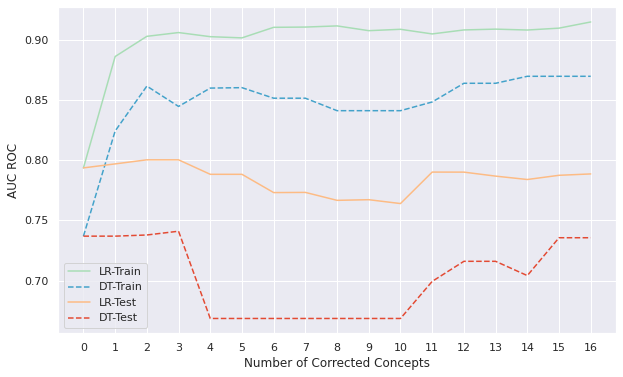

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#https://colorbrewer2.org/#type=sequential&scheme=OrRd&n=3
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})

fig, ax = plt.subplots()
sns.lineplot(data=aucs_lr[:17], color = "#a8ddb5",label='LR-Train')
sns.lineplot(data=aucs_dt[:17], color = "#43a2ca",label='DT-Train',linestyle='--')
sns.lineplot(data=aucs_lr_test[:17], color = "#fdbb84",label='LR-Test')
sns.lineplot(data=aucs_dt_test[:17], color = "#e34a33",label='DT-Test', linestyle='--')
ax.set_xticks(range(0,17))
plt.xlabel("Number of Corrected Concepts")
plt.ylabel("AUC ROC")
#ax.set_yticks([i/100.0 for i in range(77,100,2)])
plt.show()
# data_plot = pd.DataFrame({"Corrected Concepts":concepts_number,"LR-Train":aucs_lr[:16], "DT-Train":aucs_dt[:16]})
# data_plot.set_index("Corrected Concepts")

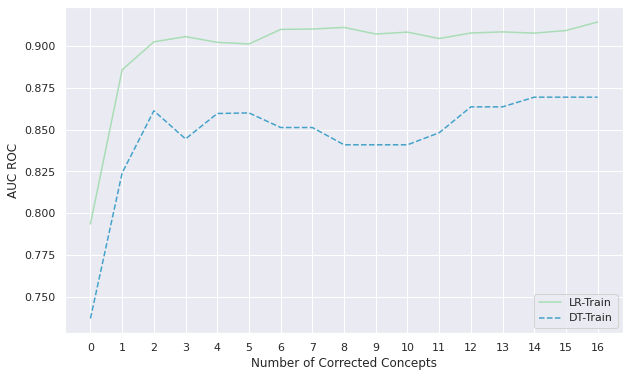

In [180]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#https://colorbrewer2.org/#type=sequential&scheme=OrRd&n=3
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})

fig, ax = plt.subplots()
sns.lineplot(data=aucs_lr[:17], color = "#a8ddb5",label='LR-Train')
sns.lineplot(data=aucs_dt[:17], color = "#43a2ca",label='DT-Train',linestyle='--')
ax.set_xticks(range(0,17))
plt.xlabel("Number of Corrected Concepts")
plt.ylabel("AUC ROC")
#ax.set_yticks([i/100.0 for i in range(77,100,2)])
plt.show()
# data_plot = pd.DataFrame({"Corrected Concepts":concepts_number,"LR-Train":aucs_lr[:16], "DT-Train":aucs_dt[:16]})
# data_plot.set_index("Corrected Concepts")

## Concept Intervention

In [39]:
CModel_method = "LR"
params = {"method": CModel_method, "concept_names": attr_names}
conc_model_lr_gt = CtLModel(X_attr_train, y_train.astype(int), **params)

y_test_pred= conc_model_lr_gt.predict(X_attr_test)
q_gt_prob= conc_model_lr_gt.clf.predict_proba(X_attr_test)[:,1]
q_gt_roc=roc_auc_score(y_test, q_gt_prob)
print("ROC AUC Score ",q_gt_roc)


ROC AUC Score  0.9204836415362732


In [40]:
concepts_names_ordered = conc_model_lr_gt.get_sorted_coef().index.values
idx_concepts= [ np.where(attr_names == i)[0][0] for i in concepts_names_ordered]

In [43]:
conc_model_lr_gt.get_sorted_coef()

,coef
Dots_globules:irregular,1.388885
Pigment_net:atypical,1.360508
BW_Veil:present,1.199856
Regression_structures:white areas,0.906943
Vascular_structures:arborizing,0.900713
Streaks:irregular,0.695946
Pigmentation:localized irregular,0.586503
Vascular_structures:hairpin,0.541035
Regression_structures:combinations,0.366018
Vascular_structures:linear-irregular,0.313192


In [44]:
concepts_names_ordered[:17]

array(['Dots_globules:irregular', 'Pigment_net:atypical',
       'BW_Veil:present', 'Regression_structures:white areas',
       'Vascular_structures:arborizing', 'Streaks:irregular',
       'Pigmentation:localized irregular', 'Vascular_structures:hairpin',
       'Regression_structures:combinations',
       'Vascular_structures:linear-irregular', 'Streaks:absent',
       'Pigmentation:diffuse irregular', 'Vascular_structures:dotted',
       'Vascular_structures:within regression',
       'Regression_structures:blue areas', 'Pigment_net:absent',
       'Dots_globules:absent'], dtype=object)

In [42]:
aucs_gt=[]
for i in range(1,len(idx_concepts)+1):
    #del conc_model_gt_i
    print('Number of concepts',i)
    conc_model_gt_i = CtLModel(X_attr_train[:,idx_concepts[:i]], y_train.astype(int), **params)
    y_test_pred = conc_model_gt_i.clf.predict_proba(X_attr_test[:,idx_concepts[:i]])[:,1]
    #score_gt = accuracy_score(y_test, y_test_pred) * 100
    roc=roc_auc_score(y_test, y_test_pred)
    aucs_gt.append(roc)
    print("ROC AUC Score - Label Predictor trained on GT concept values: ", roc,'\n')

Number of concepts 1
ROC AUC Score - Label Predictor trained on GT concept values:  0.7843883357041253 

Number of concepts 2
ROC AUC Score - Label Predictor trained on GT concept values:  0.8440611664295874 

Number of concepts 3
ROC AUC Score - Label Predictor trained on GT concept values:  0.8795163584637269 

Number of concepts 4
ROC AUC Score - Label Predictor trained on GT concept values:  0.8786628733997155 

Number of concepts 5
ROC AUC Score - Label Predictor trained on GT concept values:  0.877311522048364 

Number of concepts 6
ROC AUC Score - Label Predictor trained on GT concept values:  0.8989331436699857 

Number of concepts 7
ROC AUC Score - Label Predictor trained on GT concept values:  0.8983641536273116 

Number of concepts 8
ROC AUC Score - Label Predictor trained on GT concept values:  0.902062588904694 

Number of concepts 9
ROC AUC Score - Label Predictor trained on GT concept values:  0.9014224751066856 

Number of concepts 10
ROC AUC Score - Label Predictor tra

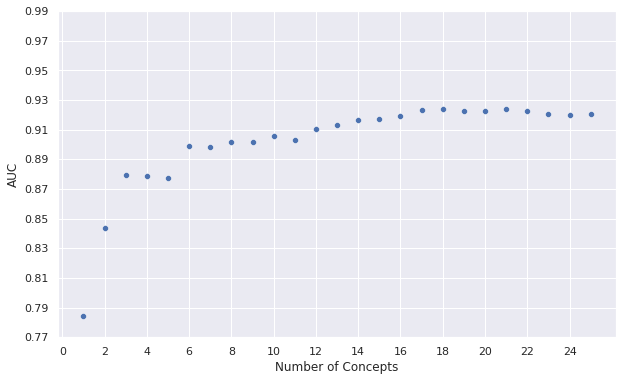

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
lr_gt_nconc_res={'Number of Concepts':range(1,26),'AUC':aucs_gt}
lr_df= pd.DataFrame(data =lr_gt_nconc_res)

import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,6)})

fig, ax = plt.subplots()
sns.scatterplot(x=lr_df['Number of Concepts'], y=lr_df['AUC'])
plt.ylim=(0, 1.1)

ax.set_xticks(range(0,26,2))
ax.set_yticks([i/100.0 for i in range(77,100,2)])
plt.show()

In [ ]:
hacer correccion en los conceptos de acuerdo al orden de importancia

In [ ]:

samples = X_attr_test[129:130]#.shape
decision_paths = clf.decision_path(samples)

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'tree.png'
graph.write_png(filename)

In [135]:


samples = X_attr_test[129:130]

In [136]:
samples

array([[0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [139]:
tes=pd.DataFrame(X_attr_test)

In [140]:
tes

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
257,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
258,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
259,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [143]:
q_dt_prob

array([0.04548635, 0.58558559, 0.95940959, 0.        , 0.04548635,
       0.        , 0.4248366 , 0.95940959, 0.        , 0.95940959,
       0.        , 0.        , 0.95940959, 0.04548635, 0.95940959,
       0.95940959, 0.        , 0.        , 0.95940959, 0.        ,
       0.04548635, 0.04548635, 0.04548635, 0.74712644, 0.        ,
       0.        , 0.4248366 , 0.04548635, 0.04548635, 0.04548635,
       0.        , 0.        , 0.8203415 , 0.04548635, 0.        ,
       0.        , 0.17426273, 0.8203415 , 0.        , 0.        ,
       0.04548635, 0.        , 0.8203415 , 0.        , 0.04548635,
       0.        , 0.8203415 , 0.17426273, 0.        , 0.74712644,
       0.        , 0.        , 0.04548635, 0.95940959, 0.58558559,
       0.8203415 , 0.95940959, 0.04548635, 0.74712644, 0.58558559,
       0.04548635, 0.58558559, 0.95940959, 0.74712644, 0.        ,
       0.74712644, 0.95940959, 0.32994924, 0.04548635, 0.8203415 ,
       0.58558559, 0.        , 0.        , 0.        , 0.     

In [157]:
index_fn=[]
for i in range(len(y_test)):
    if y_test[i]==1 and q_dt_prob[i]<0.5 and q_prob_2[i]<0.5:
        print (i,y_test[i],q_dt_prob[i],q_prob_2[i] )
        index_fn.append(i)


3 1.0 0.0 0.3732637644767676
26 1.0 0.4248366013071896 0.07462093941222195
47 1.0 0.1742627345844504 0.08899477700709621
48 1.0 0.0 0.04735535736976835
50 1.0 0.0 0.08938082493600626
64 1.0 0.0 0.1295609923997123
87 1.0 0.0 0.07243536436523741
92 1.0 0.045486354093771844 0.06899057110208191
110 1.0 0.0 0.047880436353248776
132 1.0 0.4248366013071896 0.04919634853723321
134 1.0 0.045486354093771844 0.030196051594350827
142 1.0 0.4248366013071896 0.07462093941222195
143 1.0 0.3299492385786802 0.2551042393459323
149 1.0 0.0 0.04786457101860745
151 1.0 0.1742627345844504 0.08899477700709621
161 1.0 0.0 0.07755551718707246
165 1.0 0.0 0.254202222263899
168 1.0 0.0 0.05890117352435143
169 1.0 0.0 0.08938082493600626
172 1.0 0.0 0.04288334288064534
199 1.0 0.045486354093771844 0.08949261357782634
218 1.0 0.045486354093771844 0.1295609923997123
220 1.0 0.0 0.030335531471882893
232 1.0 0.0 0.1295609923997123
233 1.0 0.0 0.008268978405078889
239 1.0 0.0 0.08272459559195876
255 1.0 0.329949238578

In [179]:
#c_test_to_inter=np.copy(c_test_extr2)

concept=1
for image_index in index_fn:
    samples = np.copy(c_test_extr2[image_index:image_index+1])
    print(image_index,samples[0,concept],X_attr_test[image_index,concept])
    if(samples[0,concept]!=X_attr_test[image_index,concept]):
        samples[0,0] = X_attr_test[image_index,0]
        samples[0,2] = X_attr_test[image_index,2]
        samples[0,concept] = X_attr_test[image_index,concept]
        nauc_lr=lr_conc_model.clf.predict_proba(samples)[:,1]
        nauc_dt=new_dt_conc_model.clf.predict_proba(samples)[:,1]
        print(nauc_lr,nauc_dt)
    

3 0.0 0.0
26 0.0 0.0
47 1.0 1.0
48 0.0 0.0
50 0.0 1.0
[0.02122393] [0.]
64 1.0 1.0
87 0.0 0.0
92 0.0 0.0
110 0.0 0.0
132 0.0 0.0
134 0.0 0.0
142 0.0 0.0
143 0.0 1.0
[0.90180137] [0.74712644]
149 0.0 0.0
151 1.0 1.0
161 0.0 0.0
165 0.0 1.0
[0.68077678] [0.]
168 0.0 1.0
[0.02122393] [0.]
169 1.0 1.0
172 0.0 0.0
199 0.0 0.0
218 0.0 1.0
[0.2259328] [0.17426273]
220 0.0 0.0
232 0.0 1.0
[0.01209668] [0.]
233 1.0 1.0
239 0.0 1.0
[0.02346635] [0.]
255 0.0 1.0
[0.82332517] [0.74712644]


In [174]:
c_test_extr

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [160]:
X_attr_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [169]:
c_test_extr2,_ = conc_extractor.predict_concepts(img_names_test)

Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
Processing batch  2  of  3
Processing batch  3  of  3
Processing batch  1  of  3
P

In [172]:
np.sum(c_test_extr==c_test_extr2)

6514

In [168]:
a=